In [1]:
import pandas as pd
import numpy as np
import matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ls Data\ for\ Diploams_Unmerged\ Data

ALL_DATA_SCHEMA_UM.pdf*  Graduation_Rates.csv*
Census_Data_2010.csv*    Max_Tract_Overlap.csv*


In [18]:
from pandas.tools.plotting import boxplot_frame_groupby

In [4]:
##### 1) READ IN DISTRICTS DATA AND CLEAN UP DEPENDENT VARIABLES

# A. read and index data
districts_unmerged = pd.read_csv("Data for Diploams_Unmerged Data/Graduation_Rates.csv")
districts_unmerged.shape
districts_unmerged_indexed_by_leaid = districts_unmerged.set_index("leaid11", verify_integrity = True)

# B. clean up dependent variable
#read in merged dataset with clean dependent vars
districts_merged = pd.read_csv("Merged Data/GRADUATION_WITH_CENSUS.csv")
districts_merged_indexed_by_leaid = districts_merged.set_index("leaid11", verify_integrity = True)


#rename dependent var col -- important for concat
new_col = districts_merged_indexed_by_leaid.columns.values
new_col[5] = "clean_grad_rate" 
districts_merged_indexed_by_leaid.columns = new_col

# concat clean grad rates with districts DF
#need to change this to a merge...
clean_grad_rates = districts_merged_indexed_by_leaid.clean_grad_rate
districts_clean = districts_unmerged_indexed_by_leaid.merge(pd.DataFrame(clean_grad_rates), left_index = True, right_index = True, how = "left")


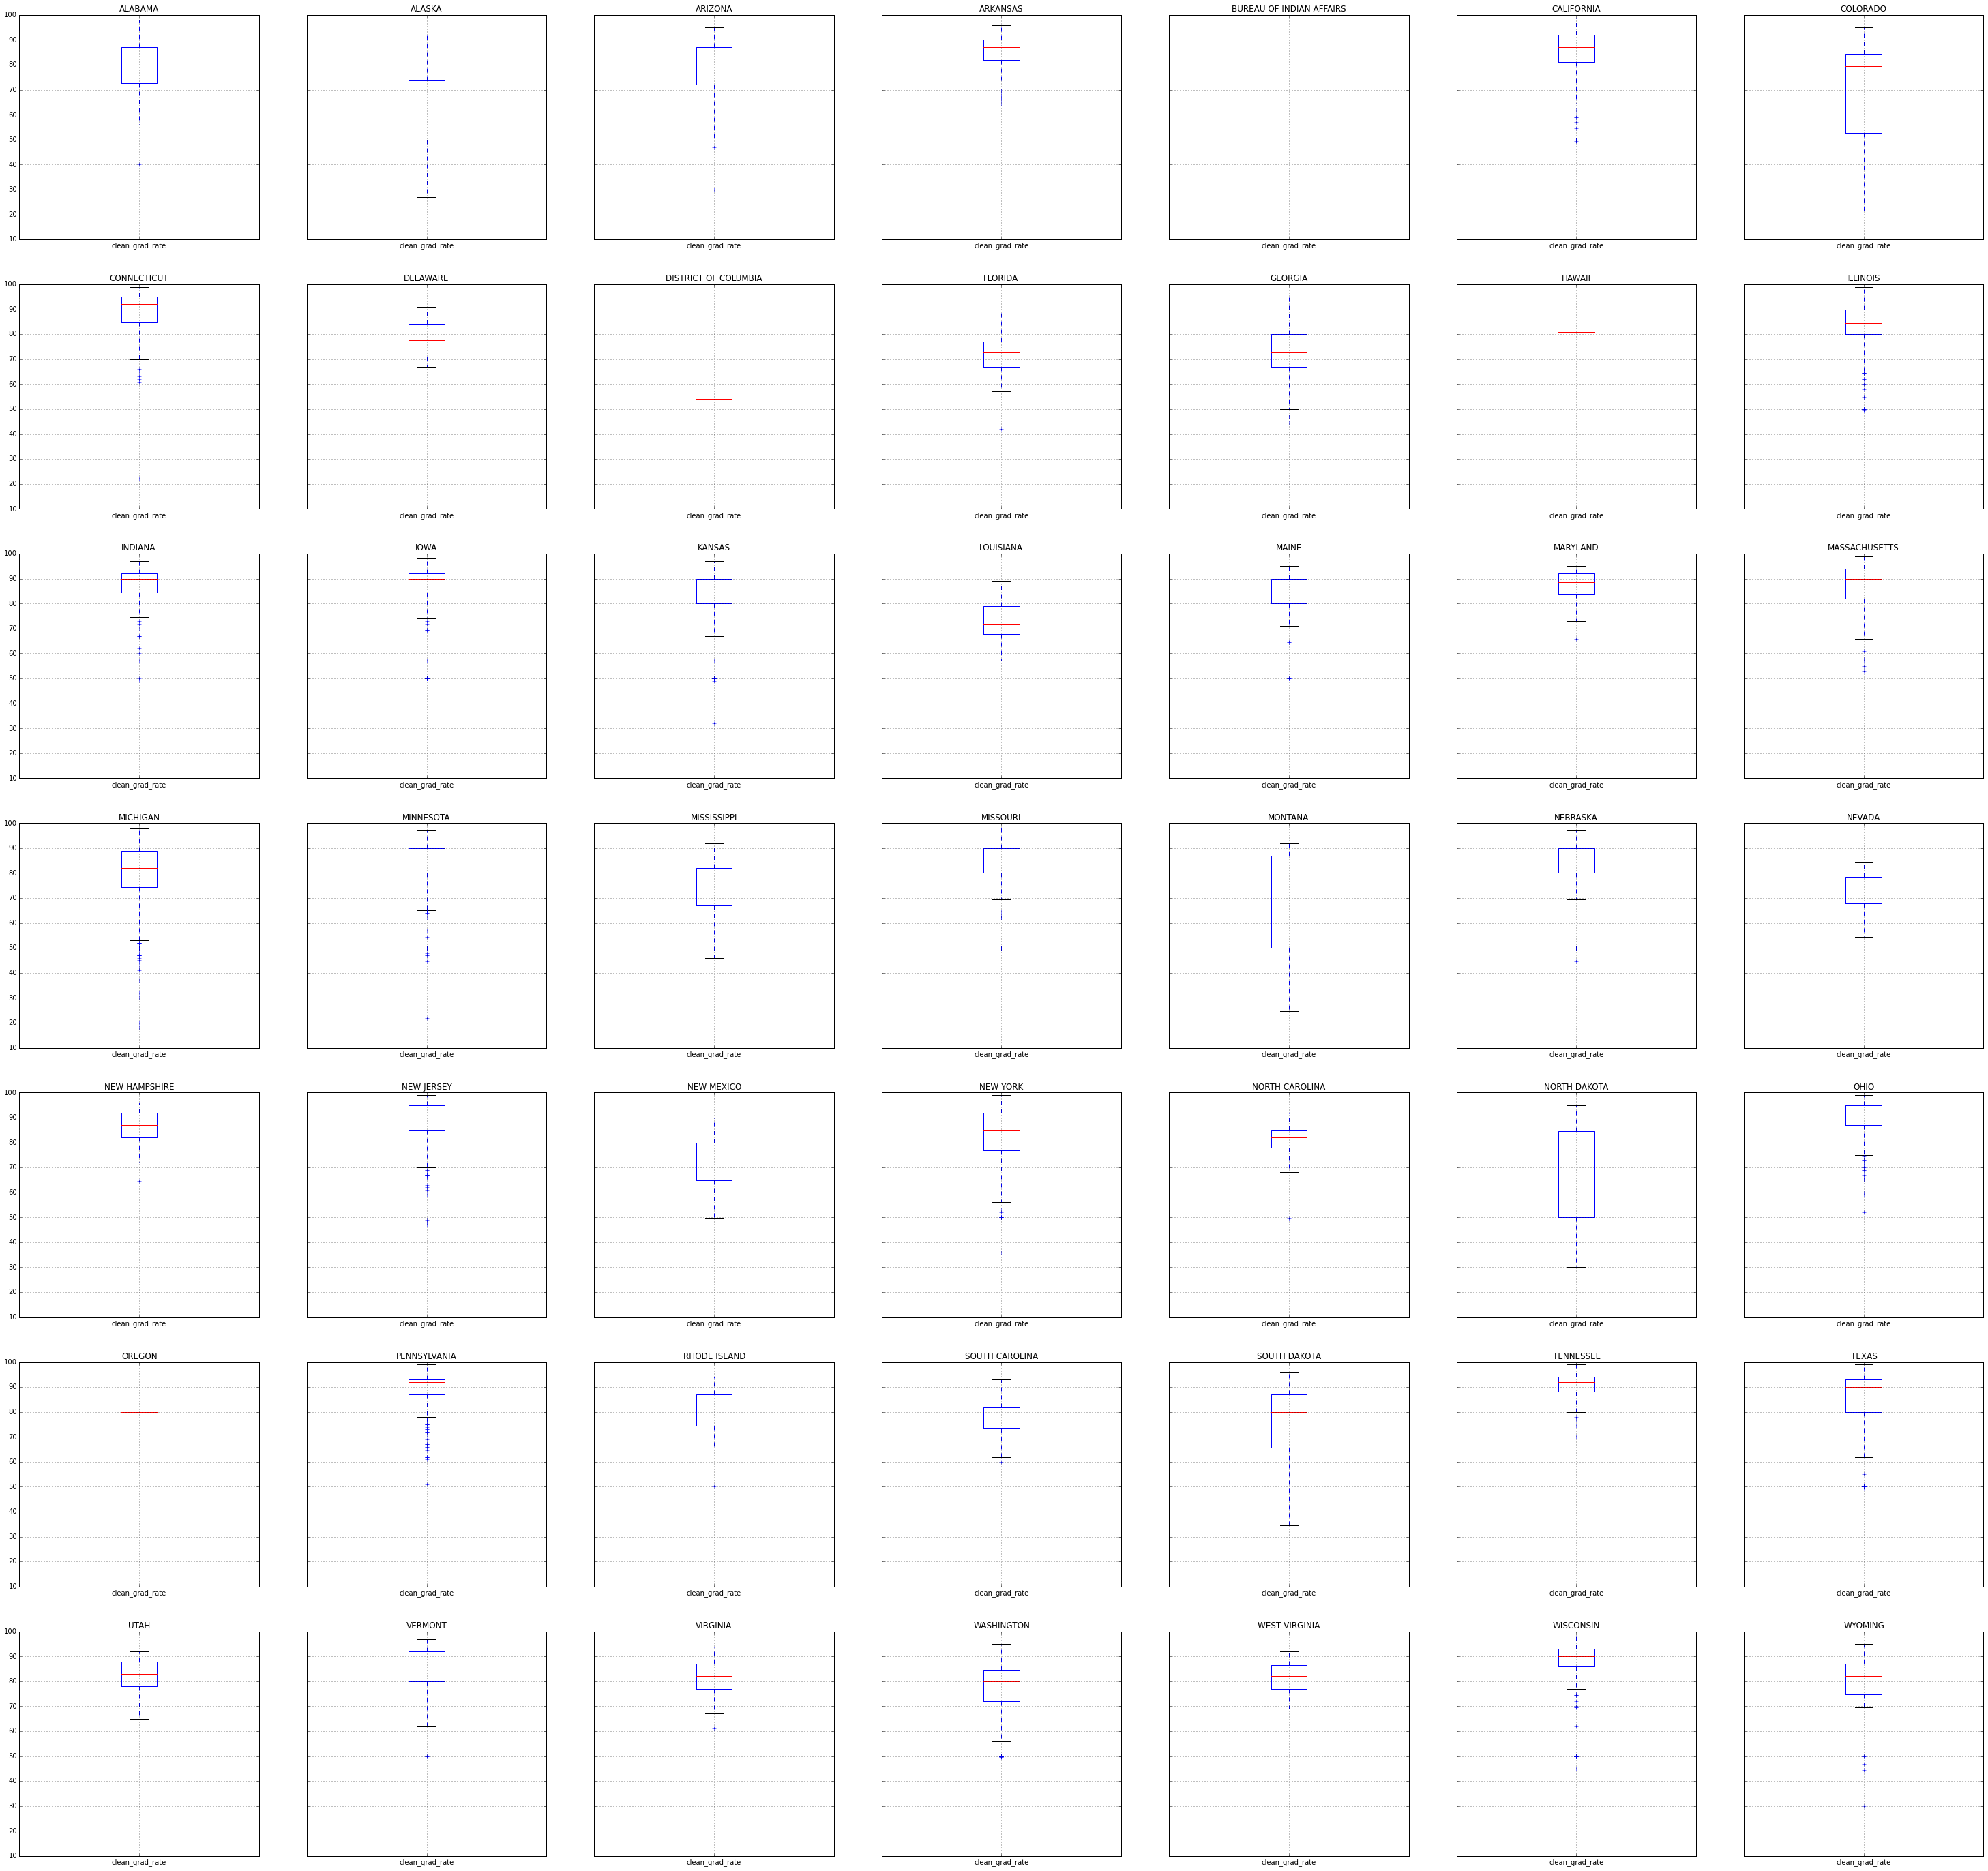

In [33]:
from matplotlib.backends.backend_pdf import PdfPages
districts_clean[["STNAM","clean_grad_rate"]].groupby("STNAM").boxplot(figsize=(50,50))
pp = PdfPages('multipage.pdf')
plt.savefig(pp, format='pdf')
pp.close()

In [23]:
districts_clean[["STNAM","clean_grad_rate"]].plot(kind='box')

ValueError: Invalid chart type given box

In [32]:
districts_clean[["STNAM","clean_grad_rate"]].groupby("STNAM").mean().sort(columns="clean_grad_rate",ascending=False)

,clean_grad_rate
STNAM,
TENNESSEE,90.281513
OHIO,90.100985
PENNSYLVANIA,89.073589
WISCONSIN,88.420424
NEW JERSEY,88.253788
CONNECTICUT,88.053719
INDIANA,87.731034
MASSACHUSETTS,87.437500
MARYLAND,86.916667


In [11]:
districts_clean[["STNAM","clean_grad_rate"]].groupby("STNAM").mean().sort(columns="clean_grad_rate",ascending=False)

,clean_grad_rate
STNAM,
TENNESSEE,90.281513
OHIO,90.100985
PENNSYLVANIA,89.073589
WISCONSIN,88.420424
NEW JERSEY,88.253788
CONNECTICUT,88.053719
INDIANA,87.731034
MASSACHUSETTS,87.437500
MARYLAND,86.916667


In [ ]:
##### 2) READ IN OTHER DATASETS, MERGE TRACT DATA WITH DISTRICT CODES, CREATE WEIGHTED VALUES
# A. read in other datasets and merge tract data with district codes
tracts = pd.read_csv("Data for Diploams_Unmerged Data/Census_Data_2010.csv")
overlap = pd.read_csv("Data for Diploams_Unmerged Data/Max_Tract_Overlap.csv")
overlap_limited = overlap[["Percentage", "State", "County", "Tract Code", " School District", " District ID", "Leaid"]]
overlap_tracts_merge = overlap_limited.merge(tracts, how="left", left_on = "Tract Code", right_on = "Tract")

# B. drop MOE and pct and avg columns -- MOEs not needed, pct/avg cols will need to be recalculated after aggregating
overlap_tracts_merge.shape

for col in overlap_tracts_merge.columns:
    if "MOE" in col or "avg" in col or "pct" in col:
        overlap_tracts_merge.drop(col, axis = 1, inplace = True)

overlap_tracts_merge.shape

# C. get weighted values

def turn_dollars_into_float(x):
    if pd.notnull(x):
        return float(x.replace("$", "").replace(",",""))
    else:
        return x
        
def fix_data_if_object_dtype(col):
    if overlap_tracts_merge[col].dtype == "object":
        overlap_tracts_merge[col] = overlap_tracts_merge[col].apply(lambda x: turn_dollars_into_float(x))

def create_new_weighted_column(col):
    weighted_col_name = "weighted_" + col
    weighted_col_value = overlap_tracts_merge.Percentage * overlap_tracts_merge[col]
    overlap_tracts_merge[weighted_col_name] = weighted_col_value

for col in overlap_tracts_merge.columns[17:]:
    #ignore median income/value columns because they can't be calculated like this
    if "Med" not in col:
        fix_data_if_object_dtype(col)
        create_new_weighted_column(col)

#also, convert dollar data into float data
overlap_tracts_merge.Med_HHD_Inc_ACS_08_12 = overlap_tracts_merge.Med_HHD_Inc_ACS_08_12.apply(turn_dollars_into_float)
overlap_tracts_merge.Med_House_value_ACS_08_12 = overlap_tracts_merge.Med_House_value_ACS_08_12.apply(turn_dollars_into_float)



In [ ]:
##### 3) START AGGREGATING AND MERGING DATA

# A. merge absolute data
def merge_column_into_districts_from_tract_data(col_name, df):
    aggregated_series = overlap_tracts_merge.groupby("Leaid")[col_name].sum()
    new_df = df.merge(pd.DataFrame(aggregated_series), left_index = True, right_index = True, how = "left")
    return new_df

for col in overlap_tracts_merge.columns:
    if "weighted_" in col:
        districts_clean = merge_column_into_districts_from_tract_data(col, districts_clean)

districts_clean
districts_clean.columns
districts_clean.shape


In [ ]:
# B. merge median value data
districts_clean["weighted_Med_HHD_Inc_ACS_08_12"] = np.NaN * len(districts_clean)
districts_clean["weighted_Med_House_value_ACS_08_12"] = np.NaN * len(districts_clean)


for i in districts_clean.index:
    tracts = overlap_tracts_merge[overlap_tracts_merge.Leaid == i]
    total_HH = districts_clean.loc[i].weighted_Tot_Housing_Units_ACS_08_12
    
    med_income = sum(tracts.Med_HHD_Inc_ACS_08_12 *(tracts.weighted_Tot_Housing_Units_ACS_08_12 / total_HH))
    med_value = sum(tracts.Med_House_value_ACS_08_12 *(tracts.weighted_Tot_Housing_Units_ACS_08_12 / total_HH))
    
    districts_clean.loc[i]["weighted_Med_HHD_Inc_ACS_08_12"] = med_income
    districts_clean.loc[i]["weighted_Med_House_value_ACS_08_12"] = med_value


In [34]:
districts_clean.weighted_Med_House_value_ACS_08_12

AttributeError: 'DataFrame' object has no attribute 'weighted_Med_House_value_ACS_08_12'